In [1]:
import sys
!{sys.executable} -m pip install qiskit qiskit_ibm_runtime numpy matplotlib pylatexenc pdflatex qiskit-aer

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt, numpy as np, cmath, math
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_vector, plot_bloch_multivector
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options, Sampler
from qiskit_aer import AerSimulator
from qiskit import *
from numpy import linalg as la
from numpy.linalg import norm
%matplotlib inline

In [3]:
def C(M,vec,n,t):
    aux = (norm(vec)*(t)**n)/np.math.factorial(n)
    return aux

def D(M,vec,n,t):
    aux=(norm(vec)*(t)**(n-1))*t/np.math.factorial(n)
    return aux

def CG(num,vec,n,t):
    aux=(norm(vec)*((num*t)**n))/np.math.factorial(n)
    return aux

def DG(num,vec,n,t):
    aux=(norm(vec)*((num*t)**(n-1))*t)/np.math.factorial(n)
    return aux

In [4]:
def gbin(dig: int, num: float):
    """
    Generates a binary number.
    
    Parameters:
    dig (int): The desired length of the binary number.
    num (float): The decimal number to convert to binary.
    
    Returns:
    list: A list representing the binary representation of the given decimal number with the specified length.
    """
    gbin = [int(x) for x in list('{0:0b}'.format(num))]
    
    for j in range(dig - len(gbin)):
        aux = [0] + gbin
        gbin = aux
    
    return gbin

In [5]:
def zeros(M):
    """
    Generates a zeros matrix.
    
    Parameters:
    M (int): The size of the square matrix.
    
    Returns:
    numpy.ndarray: A zeros matrix of size MxM.
    """
    a = [0.0]
    for i in range(M - 1):
        a = a + [0.0]
    
    b = [a]
    for i in range(M - 1):
        c = np.concatenate((b, [a]), axis=0)
        b = c
    
    return c

In [6]:
def uoseq(n, m):
    """
    Creates an unordered sequence.

    Parameters:
    n (int): The starting value of the sequence.
    m (int): The length of the sequence.

    Returns:
    list: An unordered sequence of length m, starting from n and decreasing.
    """

    v = [n]
    for i in range(m - 1):
        v = v + [n - i - 1]
    return v

In [7]:
def oseq(init, fin):
    """
    Creates an ordered sequence.
    
    Parameters:
    init (int): The initial value of the sequence.
    fin (int): The final value of the sequence.
    
    Returns:
    list: An ordered sequence starting from init and ending at fin.
    """
    v = [init]
    n = fin - init
    for i in range(n):
        v = v + [init + i + 1]
    return v


In [8]:
def summat(m1, m2):
    """
    Perform the sum of each element of a given matrix
    with its correspondent element of another matrix.
    
    Parameters:
    m1 (list): The first matrix.
    m2 (list): The second matrix.
    
    Returns:
    list: A matrix resulting from the element-wise sum of m1 and m2.
    """
    dim = len(m1)
    s = zeros(dim)
    
    for i in range(dim):
        for j in range(dim):
            s[i][j] = m1[i][j] + m2[i][j]
    
    return s

In [9]:
def unitarygen(thet):
    """
    Generates a unitary matrix based on a list of angles.

    Parameters:
    thet (list): List of angles.

    Returns:
    numpy.ndarray: The resulting unitary matrix.
    """
    dim = len(thet)
    prod = np.array([[1]])

    for i in range(dim):
        t = thet[i] / 2
        fac = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
        aux = prod
        prod = np.kron(fac, aux)

    return prod

In [10]:
def divmat(M, e):
    """
    Divide each element of a given matrix by a scalar.

    Parameters:
    M (list): The input matrix.
    e (float): The scalar divisor.

    Returns:
    list: A matrix resulting from dividing each element of M by e.
    """
    dim = len(M)
    A = zeros(dim)

    for i in range(dim):
        for j in range(dim):
            A[i][j] = M[i][j] / e

    return A

In [11]:
def ang(vec):
    """
    Evaluate parameters for rotation matrices used with controlled operators.

    Parameters:
    vec (list): The vector for which rotation matrix parameters are calculated.

    Returns:
    tuple: A tuple containing the following elements:
        int: Dimension of the vector.
        int: Logarithm base 2 of the vector dimension.
        complex: Parameter 's'.
        list: Matrix 'y'.
        list: Matrix 'z'.
    """
    dim = len(vec)
    n = int(np.log2(dim))
    y = zeros(dim)
    z = zeros(dim)
    c = zeros(dim)
    a = zeros(dim)
    nums = [0] * dim

    for m in range(dim):
        c[n][m] = abs(vec[m])
        a[n][m] = cmath.phase(vec[m])

    auxn = [0] * n
    for m in range(n):
        auxn[m] = n - m - 1

    for aux in auxn:
        for j in range(pow(2, aux)):
            k = j * 2
            cateto1 = c[aux + 1][k]
            cateto2 = c[aux + 1][k + 1]
            hip = np.sqrt(pow(cateto1, 2) + pow(cateto2, 2))
            formatted_string = "{:.6f}".format(hip)
            var = float(formatted_string)
            if (var != 0.000000):
                y[aux][j] = 2 * np.arctan2(cateto2, cateto1)
            else:
                y[aux][j] = 0.0
            c[aux][j] = hip

            if (aux != 0):
                z[aux][j] = -a[aux + 1][k] + a[aux + 1][k + 1]
                a[aux][j] = a[aux + 1][k] + 0.5 * z[aux][j]
            else:
                z[aux][j] = -2 * a[aux + 1][k]
                s = a[aux + 1][k + 1] - 0.5 * z[aux][j]

    return dim, n, s, y, z

In [12]:
def prep(vec):
    """
    Perform the encoding part for the Tao Xin method.

    Parameters:
    vec (list): The vector used for encoding.

    Returns:
    QuantumCircuit: The quantum circuit representing the encoding process.
    """
    tam, qbits, shift, ang_y, ang_z = ang(vec)
    ycircuit = QuantumCircuit(qbits)
    zcircuit = QuantumCircuit(qbits)
    
    # Applying single-qubit gates on the last qubit
    ycircuit.ry(ang_y[0][0], qbits - 1)
    zcircuit.rz(ang_z[0][0], qbits - 1)
    
    
    indices = [0] * (qbits - 1)
    for m in range(qbits - 1):
        indices[m] = m + 1
    
    # Applying controlled gates based on angle matrices
    for indice in indices:
        for j in range(pow(2, indice)):
            qcz = QuantumCircuit(1)
            qcy = QuantumCircuit(1)
            qcy.ry(ang_y[indice][j], 0)
            qcz.rz(ang_z[indice][j], 0)
            k = j * pow(2, qbits - indice)
            vec = gbin(qbits, k)
            
            # Apply X gates based on binary representation
            for i in range(indice):
                if vec[i] == 0:
                    ycircuit.x(qbits - i - 1)
                    zcircuit.x(qbits - i - 1)
            
            con_y = qcy.to_gate().control(indice)
            con_z = qcz.to_gate().control(indice)
            ycircuit.append(con_y, uoseq(qbits - 1, indice) + [qbits - 1 - indice])
            zcircuit.append(con_z, uoseq(qbits - 1, indice) + [qbits - 1 - indice])
            
            # Undo the X gates
            for i in range(indice):
                if vec[i] == 0:
                    ycircuit.x(qbits - i - 1)
                    zcircuit.x(qbits - i - 1)
    
    # Composing the quantum circuit for encoding
    cirprep = QuantumCircuit(qbits)
    cirprep = cirprep.compose(ycircuit, range(qbits))
    cirprep.p(shift, qbits - 1)
    cirprep = cirprep.compose(zcircuit, range(qbits))
    
    return cirprep

In [13]:
def getsol(vec, anc, num):
    """
    Perform the decoding process to obtain the output from Tao Xin algorithms.

    Parameters:
    vec (list): The input vector from Tao Xin algorithms.
    anc (int): The number of ancillary qubits used in the encoding.
    num (float): A numerical factor used in the decoding.

    Returns:
    list: The decoded solution obtained from Tao Xin algorithms.
    """
    sol = [0]
    tam = len(vec)
    dig = math.ceil(np.log2(tam))
    
    for i in range(tam):
        alg = gbin(dig, i)
        aux = 0
        for j in range(anc):
            aux = aux + alg[j]
        
        if aux == 0:
            sol = sol + [vec[i] * num]
    
    return sol

In [14]:
def txun(M, b, x0, t, k):
    """
    Tao Xin algorithm to solve linear differential equations (LDEs) systems in the unitary case.

    Parameters:
    M (list): The matrix representing the system of linear differential equations.
    b (list): The vector representing the constant term in the system.
    x0 (list): The initial condition vector.
    t (float): The time parameter.
    k (int): The precision parameter.

    Returns:
    tuple: A tuple containing the following elements:
        float: The normalization factor alep.
        QuantumCircuit: The quantum circuit representing the Tao Xin algorithm.
    """
    N = len(x0)
    n = math.ceil(np.log2(N))
    anc = math.ceil(np.log2(k + 1))
    Cnum = 0.0
    Dnum = 0.0
    vc = [0] * (2 ** anc)
    vd = [0] * (2 ** anc)
    aux = 0.0

    # Calculate normalization factors
    for i in range(k + 1):
        aux = aux + C(M, x0, i, t)
    Cnum = np.sqrt(aux)
    
    aux = 0.0
    for i in range(k):
        aux = aux + D(M, b, i + 1, t)
    Dnum = np.sqrt(aux)
    
    alep = np.sqrt(Cnum**2 + Dnum**2)

    # Calculate coefficients
    for i in range(k + 1):
        vc[i] = np.sqrt(C(M, x0, i, t)) / Cnum
    
    for i in range(k):
        vd[i] = np.sqrt(D(M, b, i + 1, t)) / Dnum
    
    v = [[Cnum / alep, Dnum / alep], [Dnum / alep, -Cnum / alep]]
    
    # Create the quantum circuit
    circ = QuantumCircuit(n + anc + 1)
    circ.unitary(v, n + anc)
    
    # Apply controlled gates for encoding initial conditions and constant term
    conUx = prep(x0).to_gate().control(1)
    conb = prep(b).to_gate().control(1)
    circ.x(n + anc)
    circ.append(conUx, [n + anc] + oseq(0, n - 1))
    circ.x(n + anc)
    circ.append(conb, [n + anc] + oseq(0, n - 1))
    
    # Apply controlled gates for encoding coefficients
    conVs1 = prep(vc).to_gate().control(1)
    conVs2 = prep(vd).to_gate().control(1)
    circ.x(n + anc)
    circ.append(conVs1, [n + anc] + oseq(n, n + anc - 1))
    circ.x(n + anc)
    circ.append(conVs2, [n + anc] + oseq(n, n + anc - 1))
    
    # Apply controlled unitary gates based on matrix powers
    circ1 = QuantumCircuit(n + anc + 1)
    A = M
    for m in range(anc):
        auxc = QuantumCircuit(n)
        mpow = la.matrix_power(A, 2**m)
        auxc.unitary(mpow, oseq(0, n - 1))
        conUm = auxc.to_gate().control(1)
        circ1.append(conUm, [n + m] + oseq(0, n - 1))
    
    # Apply controlled gates for decoding coefficients
    conVs1dag = prep(vc).to_gate().inverse().control(1)
    conVs2dag = prep(vd).to_gate().inverse().control(1)
    circ1.x(n + anc)
    circ1.append(conVs1dag, [n + anc] + oseq(n, n + anc - 1))
    circ1.x(n + anc)
    circ1.append(conVs2dag, [n + anc] + oseq(n, n + anc - 1))
    circ1.unitary(v, n + anc).inverse()
    circ = circ.compose(circ1, range(n + anc + 1))
    
    return alep, circ

In [15]:
def txp(M, mats, coefs, b, x_0, t, k):
    """
    Tao Xin algorithm to solve linear differential equations (LDEs) systems with particular solutions.

    Parameters:
    M (list): The matrix representing the system of linear differential equations.
    mats (list): List of matrices representing particular solutions for the system.
    coefs (list): List of coefficients for particular solutions.
    b (list): The vector representing the constant term in the system.
    x_0 (list): The initial condition vector.
    t (float): The time parameter.
    k (int): The precision parameter.

    Returns:
    tuple: A tuple containing the following elements:
        float: The value of S.
        QuantumCircuit: The quantum circuit representing the Tao Xin algorithm.
    """
    n = math.ceil(np.log2(len(x_0)))
    L = len(coefs)
    qdits = math.ceil(np.log2(L))
    arr = [0] * L
    soma = 0.0
    
    for i in range(L):
        soma = soma + coefs[i]
    
    fator = soma
    
    aux = 0.0
    for i in range(L):
        aux = aux + coefs[i]
    
    g1 = 0.0
    for i in range (k + 1):
        g1 = g1 + CG(fator, x_0, i, t)
    g1 = np.sqrt(g1)
    
    g2 = 0.0
    for i in range(k):
        g2 = g2 + DG(fator, b, i + 1, t)
    g2 = np.sqrt(g2)
    
    S = g1**2 + g2**2
    
    c = np.sqrt(g1**2 + g2**2)
    v = [[g1/c, g2/c], [g2/c, -g1/c]]
    
    reg = 1 + k + k * qdits + n
    circ = QuantumCircuit(reg)
    circ.unitary(v, reg - 1)
    
    vecV = [0] * (2 ** qdits)
    for i in range(L):
        vecV[i] = np.sqrt(coefs[i])
    gate = prep(vecV).to_gate()
    
    for i in range(k):
        init = n + i * qdits
        fin = init + qdits - 1
        circ.append(gate, oseq(init, fin))
    
    conUx = prep(x_0).to_gate().control(1)
    conb = prep(b).to_gate().control(1)
    circ.x(reg - 1)
    circ.append(conUx, [reg - 1] + oseq(0, n - 1))
    circ.x(reg - 1)
    circ.append(conb, [reg - 1] + oseq(0, n - 1))
    circ.barrier()
    
    vecs1 = [0] * (2 ** k)
    vecs2 = [0] * (2 ** k)
    for j in range(k + 1):
        ind = 2 ** k - 2 ** (k - j)
        vecs1[ind] = np.sqrt(CG(fator, x_0, j, t))
    
    for j in range (k):
        ind = 2 ** k - 2 ** (k - j)
        vecs2[ind] = np.sqrt(DG(fator, b, j + 1, t))
    
    a1 = norm(vecs1)
    a2 = norm(vecs2)
    
    for j in range(2 ** k):
        vecs1[j] = vecs1[j] / a1
        vecs2[j] = vecs2[j] / a2
    
    convs1 = prep(vecs1).to_gate().control(1)
    convs2 = prep(vecs2).to_gate().control(1)
    circ.x(reg - 1)
    circ.append(convs1, [reg - 1] + oseq(n + k * qdits, n + k * qdits + k - 1))
    circ.x(reg - 1)
    circ.append(convs2, [reg - 1] + oseq(n + k * qdits, n + k * qdits + k - 1))
    circ.barrier()
    
    for i in range(k):
        for j in range(L):
            vec = gbin(qdits, j)
            auxc = QuantumCircuit(n)
            auxc.unitary(mats[j], oseq(0, n - 1))
            gate = auxc.to_gate().control(qdits + 1)
            fin = reg - k - 2 - i * qdits
            init = fin - qdits + 1
            for h in range(qdits):
                if vec[h] == 0:
                    circ.x(init + h)
            circ.append(gate, [reg - 2 - i] + oseq(fin - qdits + 1, fin) + [0, n - 1])
    
    for h in range(qdits):
        if vec[h] == 0:
            circ.x(init + h)
        circ.barrier()
    
    convs1dag = prep(vecs1).to_gate().inverse().control(1)
    convs2dag = prep(vecs2).to_gate().inverse().control(1)
    circ.x(reg - 1)
    circ.append(convs1dag, [reg - 1] + oseq(n + k * qdits, n + k * qdits + k - 1))
    circ.x(reg - 1)
    circ.append(convs2dag, [reg - 1] + oseq(n + k * qdits, n + k * qdits + k - 1))
    circ.barrier()
    
    gatedag = prep(vecV).to_gate().inverse()
    for i in range(k):
        init = n + i * qdits
        fin = init + qdits - 1
        circ.append(gatedag, oseq(init, fin))
    
    circ.unitary(v, reg - 1).inverse()
    return S, circ

/tmp/ipykernel_34515/1878907266.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  taoxi[count] = sol[4]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[3.31404679e+00 4.77714580e+00 6.39897367e+00 8.18943147e+00
 1.01586448e+01 1.23169635e+01 1.46749622e+01 1.72434397e+01
 2.00334194e+01 2.30561490e+01 2.63231008e+01 2.98459716e+01
 3.36366824e+01 3.77073788e+01 4.20704311e+01 4.67384335e+01
 5.17242052e+01 5.70407894e+01 6.27014542e+01 6.87196917e+01
 7.51092189e+01 8.18839768e+01 8.90581311e+01 9.66460721e+01
 1.04662414e+02 1.13121996e+02 1.22039882e+02 1.31431360e+02
 1.41311942e+02 1.51697364e+02 1.62603588e+02 1.74046801e+02
 1.86043411e+02 1.98610054e+02 2.11763589e+02 2.25521099e+02
 2.39899893e+02 2.54917502e+02 2.70591684e+02 2.86940420e+02
 3.03981915e+02 3.21734601e+02 3.40217132e+02 3.59448386e+02
 3.79447469e+02 4.00233706e+02 4.21826652e+02 4.44246083e+02
 4.67512001e+02 4.91644631e+02 5.16664424e+02 5.42592054e+02
 5.69448421e+02 5.97254648e+02 6.26032084e+02 6.55802301e+02
 6.86587096e+02 7.18408491e+02 7.51288732e+02 7.85250288e+02
 8.20315855e+02 8.56508352e+02 8.93850924e+02 9.32366937e+02
 9.72079985e+02 1.013013

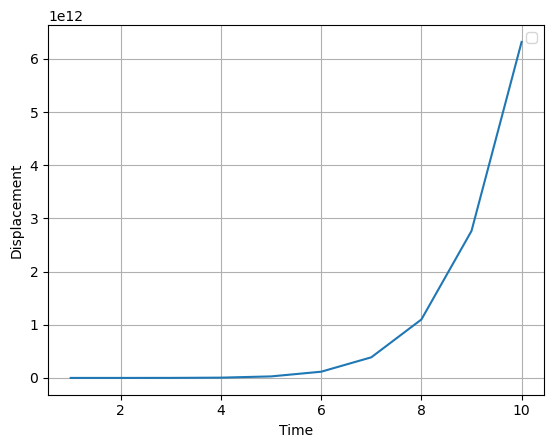

In [33]:
# IBMQ API SETTINGS.
# Keep it commented if running locally
#
# service = QiskitRuntimeService(channel="ibm_quantum", token="<YOUR-IBMQ-TOKEN>")
# options = Options()
# options.resilience_level = 1
# options.optimization_level = 3
backend = BasicAer.get_backend('statevector_simulator')
# backend = service.backend('simulator_statevector')

# Creates the quantum circuit given initial conditions and displays the circuit.
#M = unitarygen([np.pi/3, np.pi/2])
#b = [0, 0, 0, 0.1]
#x0 = [0, 0, 0, 0.1]

m = 1
k = 10
c = 0.1


M = ([-k/m , -c/(2*m)],[0,1])

A1 = unitarygen([np.pi/4, np.pi/3])
A2 = unitarygen([np.pi/4, np.pi/3])
A3 = unitarygen([np.pi/4, np.pi/3])

#M = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
b = [1,1,1,1]
x0 = [1,5,4,2]
#N,circuit = txun(M, b, x0, 0.1, 4)

ti = 1
dt = 1
tf = 10.0
i = int(tf/dt)
time = np.linspace(ti, tf, i)
taoxi = np.zeros(len(time))
count = 0
for i in time:
    N,circuit = txp(M, [A1,A2,A3],[1, 2, 3] , b, x0, i, 4)
    # Transpile the circuit and execute.
    compiled_circuit = transpile(circuit, backend)
    result = execute(compiled_circuit, backend).result()

    # Getting solutions.
    psi = result.get_statevector()
    sol = (getsol(psi, 4, N**2))
    
    taoxi[count] = sol[4]
    count += 1
    
print(taoxinuni)

# Plot results
plt.plot(time, taoxi)
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.grid(True)
plt.legend()
plt.show()


#display(circuit.draw())

# Transpile the circuit and execute.
#compiled_circuit = transpile(circuit, backend)
#result = execute(compiled_circuit, backend).result()

# Getting solutions.
#psi = result.get_statevector()
#sol = (getsol(psi, 4, N**2))

# Data processing.
#print(psi)
#print(sol)
#plot_bloch_multivector(psi)